In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from crocValueData import *
from termData import *
from termModel import *
from ValueNetwork import *

In [3]:
p, v = base_data()

In [4]:
# Generate a neural network
costNet = ValueNet(p.shape[1], v.shape[1])

In [5]:
costNet = trainValueNet(costNet, p, v)

100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


In [6]:
states, values = terminalData(costNet)

100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


In [7]:
costNet2 = trainValueNet(costNet, states, values)

100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


In [8]:
import crocoddyl
import numpy as np
from termModel import *
from tqdm import tqdm

model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.matrix([1,1]).T
costNet2.eval()
terminalModel = UnicycleTerminal(costNet2)
    


positions = []
croc_xs = []
croc_cost = []
croc_iters = []

torch_predictions = []


ddp_with_net_xs = []
ddp_with_net_cost = []
ddp_with_net_iters = []

for _ in tqdm(range(1000)):
    x0 = np.array([np.random.uniform(-2.1, 2.1), np.random.uniform(-2.1, 2.1), np.random.uniform(0,1)])
    T = 30
    positions.append(x0)
    problem = crocoddyl.ShootingProblem(x0.T, [ model ] * T, model)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve()
    croc_xs.append(ddp.xs[-1].tolist())
    croc_cost.append(np.array([ddp.cost]))
    croc_iters.append(np.array([ddp.iter]))
    
    test = torch.as_tensor(x0, device = device, dtype = torch.float32).resize_(1, 3)
    prediction = costNet2(test)
    torch_predictions.append(prediction)
    
    
    problem2 = crocoddyl.ShootingProblem(x0.T, [ model ] * T, terminalModel)
    ddp2 = crocoddyl.SolverDDP(problem2)
    ddp2.solve()
    ddp_with_net_xs.append(ddp2.xs[-1].tolist())
    ddp_with_net_cost.append(np.array([ddp2.cost]))
    ddp_with_net_iters.append(np.array([ddp2.iter]))

100%|██████████| 1000/1000 [07:25<00:00,  2.24it/s]


In [9]:
    
positions = np.array(positions)
croc_xs = np.array(croc_xs).squeeze()
croc_cost = np.array(croc_cost)
croc_iters = np.array(croc_iters)


ddp_with_net_xs = np.array(ddp_with_net_xs).squeeze()
ddp_with_net_cost = np.array(ddp_with_net_cost)
ddp_with_net_iters = np.array(ddp_with_net_iters)    

In [10]:
torch_predicted_cost = []
for a in torch_predictions:
    b = a.cpu().detach().numpy()
    torch_predicted_cost.append(b)
torch_predicted_cost = np.array(torch_predicted_cost).squeeze().reshape(1000, 1)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [16]:
c_cost_VS_t_p_cost_mse = mean_squared_error(croc_cost, torch_predicted_cost)
c_cost_VS_t_p_cost_mae = mean_absolute_error(croc_cost, torch_predicted_cost)
c_cost_VS_t_p_cost_r2 = r2_score(croc_cost, torch_predicted_cost)


c_cost_VS_ddp_net_cost_mse = mean_squared_error(croc_cost, ddp_with_net_cost)
c_cost_VS_ddp_net_cost_mae = mean_absolute_error(croc_cost, ddp_with_net_cost)
c_cost_VS_ddp_net_cost_r2 = r2_score(croc_cost, ddp_with_net_cost)



c_xs_VS_ddp_xs_mse = mean_squared_error(croc_xs, ddp_with_net_xs)
c_xs_VS_ddp_xs_mae = mean_absolute_error(croc_xs, ddp_with_net_xs)
c_xs_VS_ddp_xs_r2 = r2_score(croc_xs, ddp_with_net_xs)

c_iters_VS_ddp_net_iters_mae = mean_absolute_error(croc_iters, ddp_with_net_iters)
c_iters_VS_ddp_net_iters_mse = mean_squared_error(croc_iters, ddp_with_net_iters)
c_iters_VS_ddp_net_iters_r2 = r2_score(croc_iters, ddp_with_net_iters)

In [22]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
%matplotlib inline

def plot_(x, y, z, name, label):

    extent = (min(x), max(x), min(y), max(y))
    xs,ys = np.mgrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:200j] #2D x,y
    z_resampled = griddata((x, y), z, (xs, ys)) #2D z
    plt.imshow(z_resampled, interpolation="none", extent=extent, origin="lower")
    plt.xticks(np.arange(-3, 3.1, step=1))
    plt.yticks(np.arange(-3, 3.1, step=1))
    clb = plt.colorbar()
    clb.set_label(label, labelpad=-40, y=1.10, rotation=0)
    plt.title(name)
    plt.savefig(f"{name + label}.png")
    plt.show()

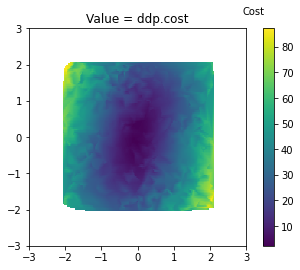

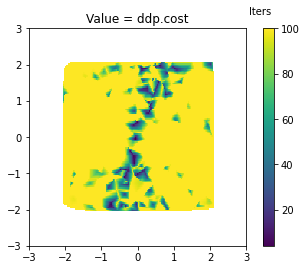

In [23]:
# For the xref network
plot_(x = positions[:,0],
      y = positions[:,1],
      z = ddp_with_net_cost[:,0], 
      name="Value = ddp.cost",
      label ="Cost")
plot_(x = positions[:,0],
      y = positions[:,1], 
      z = ddp_with_net_iters[:,0],
      name="Value = ddp.cost",
      label = "Iters")

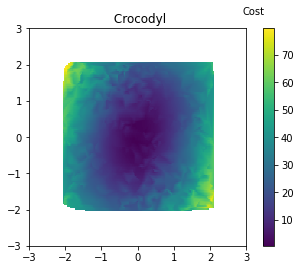

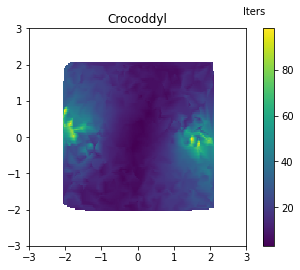

In [24]:
plot_(x = positions[:,0],
      y = positions[:,1],
      z = croc_cost[:,0], 
      name=" Crocodyl",
      label ="Cost")
plot_(x = positions[:,0],
      y = positions[:,1], 
      z = croc_iters[:,0],
      name="Crocoddyl",
      label = "Iters")

In [21]:
print(c_iters_VS_ddp_net_iters_mse) 
print(c_iters_VS_ddp_net_iters_mae) 
print(c_iters_VS_ddp_net_iters_r2)

5804.683
72.047
-25.184539587051095


#### Summary:

    Two networks:
        1: Value Networks ----> Predicts cost
        2: XRef Networks ------> Predicts Xref , 
                Xref is then used to calculate cost  through ||x -xref|| ** 2
                
    Crocddyl is then run twice.
    First Case: Crocddyl has terminalModel with Value Network in it.
        The value Network is differentiated to given the Jacobian and Hessian
    
    Second Case: Crocoddyl has terminalModel with XrefNetwork in it.
        This XrefNetwork predicts xref
        The function ||x - xref|| **2 is then differentiated to compute the Jacobian and Hessian.
        In this case the neural net is not getting differentiated.
        
##### For the Value Network:

    1: Comparing predictions by Value Network with Crocoddyl
        1: MSE       = 27.60
        2: MAE       = 4.56
        3: R2 score  = 0.89
     
    2: Comparing crocoddyl cost(with terminalModel(value network) with Crocoddyl
        1: MSE        = 47.15
        2: MAE        = 6.16
        3: R2 score   = 0.82
        
##### For the Xref Network:

    1: Comparing xref predicted by Xref Net with Crocoddyl xref
        1: MSE        = 0.003
        2: MAE        = 0.04007
        3: R2 Score   = 0.915

    2: Comparing crocoddyl xref(with terminalModel(Xref network) with Crocoddyl Xref
        1: MSE        = 0.00195
        2: MAE        = 0.02887
        2: R2 Score   = 0.94057
        
    3: Comparing crocoddyl COST(with terminalModel(Xref network) with Crocoddyl COST
        1: MSE        = 0.066       
        2: MAE        = 0.195
        3: R2 Score   = 0.99
        
        
 For Just Crocoddyl:
  <table>
    <tr><td><img src=" ccost.png"></td><td><img src="CrocoddylIters.png"></td></tr>
</table>

 For Crocoddyl with Value Network:
  <table>
    <tr><td><img src=" Value = ddp.costCost.png"></td><td><img src="Value = ddp.costIters.png"></td></tr>
</table>

 For Just Crocoddyl:
  <table>
    <tr><td><img src=" ccost.png"></td><td><img src="CrocoddylIters.png"></td></tr>
</table>